## Analysis of collaborative- and content-based recommendation systems
#### Dataset: [MovieLens 20M](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset)
##### Task for internship at VK Core ML

#### Model Description

I will build a two stage model. First stage will be collaborate filtering model (matrix factorization from LightFM library). The second stage will use the predictions from collaborative model along with the movie features to further reorder the ranks of the recommended movies. In the second stage I will use boosting model from the CatBoost library. Benefits of the approach: <br>
- boosting model will only rearrange collaborative model's recommendations; ranking all the movies would be computationally heavy for boosting model
- combines both approaches by effectively using the features
- it has capacity of using multiple collaborative models (ensembling in the first stage) 

<center><img src="model.jpg" alt="Drawing" style="width: 450px;"/></center>

#### Train and Test Split

I will initially split data into global train and test sets. They will be split based on temporal features (for example, train 1995-2001 and test 2011-2015). Different movies are popular at different period of times and temporal way of splitting data makes sense. <br>

Train will further be split into two parts: one for training collaborative model and another one for training boosting model. Collaborative model will also be invdividually validated on the testing set. Boosting model's training set will have its own validation subset for early stopping of the model. <br>

For general model's validation ideally it would be good to perform k-fold validation but due to limited amount of time I will not do that. <br>

<center><img src="data.jpg" alt="Drawing" style="width: 450px;"/></center>

#### Choice of a Metric

For choosing the metric I refered to the following Github repo: [recmetrics](https://github.com/statisticianinstilettos/recmetrics). It provides different metrics specifically tailored for analysis of the performance of recommendation systems. Below are the ones I have chosen for this specific task: <br>
- **Precision @ K:** how precise is our model at predicting rank at a specific position
- **Recall @ K:** how good model at recalling the rank at specific position
- **Mean Average Precision @ K (MAP@K):** average of precision's up to K
- **Mear Reciprocal Rank (MRR)**: 1 / highest_ranked_answer; higher the value better the model at predicting the first order ranks
<!-- - **Coverage:** metric checks how well model recalls items from the whole training set; so it is similar to recall but on a macro scale of checking how well model is doing in general; it's good metric for seeing whether our model can operate well in case of recommending less popular items because very often certain movies dominate the dataset and MAP@k and MAR@k might end up having high values
- **Personalization:** it's the dissimilarity between user's lists of recommendations. A high score indicates user's recommendations are different, which means that model is good at adapting for individual cases and not just recommending most common items -->

### Code

In [1]:
# Imports
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from lightfm.data import Dataset
from lightfm import LightFM

from catboost import CatBoostClassifier

from tools import (
    generate_lightfm_recs_mapper, compute_metrics, 
    train_test_split_custom, sample_hyperparameters, 
    random_search
)

import warnings
warnings.simplefilter('ignore')

##### Initial Data Preparation

First we will prepare data for training

Below we will parse the movies dataframe to extract genres as features (each genre will be a column). This will be needed for the second stage of the model.

In [3]:
df_movies = pd.read_csv('movie.csv')

In [4]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# Get list of unique genres present in the dataset
unique_genres = set()
for i in range(df_movies.shape[0]):
    genres = df_movies.iloc[i, 2]
    for cur_genre in genres.split('|'):
        unique_genres.add(cur_genre)

genre_columns = list(unique_genres)
genre_columns = [str(i) for i in genre_columns]

In [6]:
# Create one-hot encoded matrix for movies genres
all_rows = []
for i in range(df_movies.shape[0]):
    cur_row = np.zeros(len(genre_columns))
    genres = df_movies.iloc[i, 2]
    for cur_genre in genres.split('|'):
        cur_row[genre_columns.index(cur_genre)] = 1.0
    all_rows.append(cur_row)

In [7]:
# Add one hot encoded genres to movies dataframe
df_genres = pd.DataFrame(np.array(all_rows), columns=genre_columns)
df_movies_with_genres = pd.concat([df_movies, df_genres], axis=1)

In [8]:
df_movies_with_genres.shape

(27278, 23)

We also will pivot genomes dataframe to use this info for training second stage of the model.

In [9]:
df_genomes = pd.read_csv('genome_scores.csv')

In [10]:
df_genomes.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [11]:
# Get the tag names for meaningful representation of columns
df_tags = pd.read_csv('genome_tags.csv')

id_to_tag_dict = {}
for i in range(df_tags.shape[0]):
    id = df_tags.iloc[i, 0]
    tag = df_tags.iloc[i, 1]
    id_to_tag_dict[id] = tag

In [12]:
# Pivot genomes table
df_genomes_pivoted = df_genomes.pivot_table(columns='tagId', index='movieId', values='relevance')
df_genomes_pivoted.rename(columns=id_to_tag_dict, inplace=True)
df_genomes_pivoted = df_genomes_pivoted.astype(int)


In [13]:
df_genomes_pivoted.shape

(10381, 1128)

Due to memory limitation we will randomly select columns for training. Ideally we would pick features that are not already present in the genres set of features or we would pick them based on the performance on the testing set.

In [14]:
df_genomes_pivoted = df_genomes_pivoted.sample(n=40, axis='columns')

In [15]:
df_genomes_pivoted.shape

(10381, 40)

In [16]:
# Merge genres and genomes data into one dataframe
df_movies_final = df_movies_with_genres.merge(df_genomes_pivoted, on='movieId', how='left')

In [17]:
df_movies_final.shape

(27278, 63)

In [19]:
# Get column names for later training use and remove redundant ones
movie_columns = list(df_movies_final.columns)
movie_columns.remove('title')
movie_columns.remove('genres')

We got the movie related data together into one dataframe and now we can look at users' ratings data and merge everything together

In [20]:
# Read ratings data
df_rating = pd.read_csv('rating.csv')

In [22]:
# Pick the users above the threshold number of ratings they put.
# This is needed for faster training due to limited time and to reduce
# noise in the training data. 
ratings_threshold = 200
filtered_ratings = df_rating['userId'].value_counts() > ratings_threshold
selected_users = filtered_ratings[filtered_ratings].index
df_rating=df_rating[df_rating['userId'].isin(selected_users)]

In [23]:
# Merge movies and ratings they have received
df_ratings_movies = df_movies_final.merge(df_rating, on='movieId')

In [24]:
# Get the number of times movies were rated for further data reduction
number_of_ratings = df_ratings_movies.groupby('title')['rating'].count().reset_index()
number_of_ratings.rename(columns={'rating':'number of ratings'}, inplace=True)

In [25]:
# Add ratings count to the main dataframe
df_main = df_ratings_movies.merge(number_of_ratings, on='title')

In [26]:
# Further filtering of data based on number of ratings movie received
df_main = df_main[df_main['number of ratings'] >= 100]

In [27]:
# Casting ratings to int
df_main['rating'] = df_main['rating'].astype(int)

In [28]:
# Split the data into train and test based on year
split_year = 2011
df_main['timestamp'] = pd.DatetimeIndex(df_main['timestamp']).year
df_train = df_main[df_main['timestamp'] < split_year]
df_test = df_main[df_main['timestamp'] > split_year]

In [29]:
df_main.columns

Index(['movieId', 'title', 'genres', 'Children', 'Thriller', 'Crime',
       'Documentary', 'Film-Noir', 'Horror', 'Mystery', 'Musical', 'Adventure',
       'Comedy', 'War', 'Romance', 'Fantasy', 'Drama', 'Western', 'Action',
       'IMAX', 'Sci-Fi', 'Animation', '(no genres listed)', 'magic',
       'author:neil gaiman', 'stoner movie', 'spielberg', 'desert',
       'imaginary friend', 'satire', 'catholicism', 'president', 'unique',
       'psychiatrist', 'better than the american version', 'italy', 'bizarre',
       'unusual plot structure', 'fun', 'dragon', 'not funny', 'cool',
       '19th century', 'affectionate', 'kidnapping', 'idealism', 'jewish',
       'dolphins', 'justice', 'brutality', 'dialogue', 'good', 'ominous',
       'teenagers', 'philosophy', 'biting', 'so bad it's funny', 'weed',
       'chicago', 'drug addiction', 'good versus evil', 'mad scientist',
       'suicide', 'userId', 'rating', 'timestamp', 'number of ratings'],
      dtype='object')

In [30]:
df_train.shape

(10418861, 67)

In [31]:
df_test.shape

(1251724, 67)

#### Two-stage Model.

##### Stage 1. Collaborative Filtering. Matrix Factorization.

For creating a collaborative filtering model I will use matrix factorization method. I will use LightFM recommendation system library that has matrix factorization-based model. But initially, I need to further process the dataset for training and validating.

In [32]:
# Get the date at which data will be further split for LightFM and boosting
lfm_date_threshold = df_train['timestamp'].quantile(q=0.7, interpolation='nearest')
lfm_date_threshold

2006

In [33]:
# lfm_pred will be used for boosting
lfm_train = df_train[(df_train['timestamp'] < lfm_date_threshold)]
lfm_pred = df_train[(df_train['timestamp'] >= lfm_date_threshold)]

print(f"lfm_train: {lfm_train.shape}")
print(f"lfm_pred: {lfm_pred.shape}")

lfm_train: (6879359, 67)
lfm_pred: (3539502, 67)


In [34]:
# Keep the data that's present in train
lfm_pred = lfm_pred[lfm_pred['userId'].isin(lfm_train['userId'].unique())]

In [35]:
# Dataset class for LightFM
dataset = Dataset()
dataset.fit(lfm_train['userId'].unique(), lfm_train['movieId'].unique())

In [36]:
# Matrix for training LightFM
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*lfm_train[['userId', 'movieId', 'rating']].values.T)
)

weights_matrix_csr = weights_matrix.tocsr()

In [37]:
# Unique user and movie mappings
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

print(f"users_mapping amount: {len(lightfm_mapping['users_mapping'])}")
print(f"items_mapping amount: {len(lightfm_mapping['items_mapping'])}")

users_mapping amount: 16361
items_mapping amount: 6108


Prior to training the final LightFM matrix factorization model we will run hyperparameter search. We will use random search approach by randomly selecting hyperparameters. We will run the hyperparameter search on the validation set that we take from the LightFM's training set. To ensure that we don't have cold users (not present in training set) in the validation set, we will only take movies that have ratings for at least 10 movies in the training set. As a metric for picking the model we will use LightFM's AUC score.

In [90]:
# Run hyperparameter search for LightFM model
train, test = train_test_split_custom(weights_matrix_csr, 5, fraction=0.2)

(score, hyperparams, model) = max(random_search(train, test, num_threads=2), key=lambda x: x[0])

print("Best score {} at {}".format(score, hyperparams))

Best score 0.9496344923973083 at {'no_components': 51, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.11138188021626874, 'item_alpha': 3.098252502431011e-08, 'user_alpha': 6.794355467420496e-12, 'max_sampled': 14, 'num_epochs': 19}


In [92]:
# Define LightFM model with optimal hyperparameters
lfm_model = LightFM(
    no_components=51, 
    learning_schedule='adagrad',
    learning_rate=0.111,
    item_alpha=3.098252502431011e-08,
    user_alpha=6.794355467420496e-12, 
    loss='warp', 
    max_sampled=14, 
    random_state=7575,
)

In [93]:
# Train LightFM model
num_epochs = 19

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(
        weights_matrix_csr
    )

  0%|          | 0/19 [00:00<?, ?it/s]

In [94]:
# Create dataframe to fill out predictions from LightFM model
candidates = pd.DataFrame({
    'userId': lfm_pred['userId'].unique()
})

candidates.head(3)

,userId
0,58
1,1165
2,2051


In [95]:
# Number of candidates for boosting training 
top_N = 30

# Predict top_N candidates using helper function from tools.py
all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=dict(),
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

In [96]:
# Generate predictions for boosting model
candidates['movieId'] = candidates['userId'].map(mapper)
candidates = candidates.explode('movieId')
candidates['rank'] = candidates.groupby('userId').cumcount() + 1 

candidates.head()

,userId,movieId,rank
0,58,1219,1
0,58,1214,2
0,58,1994,3
0,58,593,4
0,58,2160,5


In [97]:
candidates.shape

(120390, 3)

#### Stage 2. Boosting. CatBoost.

We setting the task as binary classification. In the end it will produce logits and we can arrange recommendations based on logit values. As positive target we setting values that have received rating of at least 2, and as negative target we are setting values that haven't been viewed at all.

In [98]:
pos = candidates.merge(lfm_pred,
                        on=['userId', 'movieId'],
                        how='inner')

pos = pos[pos['rating'] > 1].reset_index()

pos['target'] = 1
print(pos.shape)

(7361, 70)


In [105]:
neg = candidates.set_index(['userId', 'movieId'])\
        .join(lfm_pred.set_index(['userId', 'movieId']))

neg = neg[neg['rating'].isnull()].reset_index()

neg = neg.sample(frac=0.14)
neg['target'] = 0

print(neg.shape)

(15803, 69)


In [106]:
# Split the data for checking catboost performance
ctb_train_users, ctb_test_users = train_test_split(lfm_pred['userId'].unique(),
                                                  random_state=1,
                                                  test_size=0.2)

In [107]:
# Use 10% for the early stopping during training
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.1)

In [108]:
select_col = ['userId', 'movieId', 'rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['userId'].isin(ctb_train_users)],
        neg[neg['userId'].isin(ctb_train_users)]
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['userId'].isin(ctb_test_users)],
        neg[neg['userId'].isin(ctb_test_users)]
])[select_col]
)

# For early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['userId'].isin(ctb_eval_users)],
        neg[neg['userId'].isin(ctb_eval_users)]
])[select_col]
)

Checking the class balance for training

In [109]:
ctb_train['target'].value_counts(normalize=True)

0    0.68309
1    0.31691
Name: target, dtype: float64

In [110]:
ctb_test['target'].value_counts(normalize=True)

0    0.680171
1    0.319829
Name: target, dtype: float64

Now we selecting classes for training. We will use features that we have formed from genres and genomes in the data processing step before.

In [111]:
user_col = ['userId']
item_col = movie_columns 

In [112]:
# We will use LightFM ranks as feature as well
train_feat = ctb_train.merge(df_movies_final[item_col],
                           on=['movieId'],
                           how='left')

eval_feat = ctb_eval.merge(df_movies_final[item_col],
                           on=['movieId'],
                           how='left')

In [113]:
# Select features for training catboost
drop_col = ['userId', 'movieId']
target_col = ['target']
cat_col = movie_columns.copy()
cat_col.remove('movieId')

In [114]:
# Remove non-feature columns for input and keep targets for output
X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]

In [115]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((16623, 61), (16623, 1), (1851, 61), (1851, 1))

In [116]:
# Cast to int for catboost training
X_train = X_train.astype(int) 
y_train = y_train.astype(int)
X_val = X_val.astype(int) 
y_val = y_val.astype(int)

In [117]:
# fillna for catboost with the most frequent value 
X_train = X_train.fillna(X_train.mode().iloc[0])

In [118]:
# fillna for catboost with the most frequent value 
X_val = X_val.fillna(X_train.mode().iloc[0])

In [123]:
# Run hyperparameter seach for catboost
ctb_search_model = CatBoostClassifier(loss_function='Logloss', silent=True)

grid = {
    'learning_rate': [0.01, 0.03, 0.1],
    'max_depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'n_estimators': [100, 500, 2000, 4000],
}

randomized_search_result = ctb_search_model.randomized_search(grid,
                                                              X=X_train,
                                                              y=y_train,
                                                              plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6250214316
bestIteration = 99

0:	loss: 0.6250214	best: 0.6250214 (0)	total: 694ms	remaining: 6.24s

bestTest = 0.6095848488
bestIteration = 329

1:	loss: 0.6095848	best: 0.6095848 (1)	total: 27.3s	remaining: 1m 49s

bestTest = 0.6103769571
bestIteration = 40

2:	loss: 0.6103770	best: 0.6095848 (1)	total: 31.8s	remaining: 1m 14s

bestTest = 0.6098735112
bestIteration = 52

3:	loss: 0.6098735	best: 0.6095848 (1)	total: 1m 10s	remaining: 1m 45s

bestTest = 0.611745058
bestIteration = 324

4:	loss: 0.6117451	best: 0.6095848 (1)	total: 1m 20s	remaining: 1m 20s

bestTest = 0.6111545398
bestIteration = 31

5:	loss: 0.6111545	best: 0.6095848 (1)	total: 1m 33s	remaining: 1m 2s

bestTest = 0.6116361176
bestIteration = 110

6:	loss: 0.6116361	best: 0.6095848 (1)	total: 2m 26s	remaining: 1m 2s

bestTest = 0.611122856
bestIteration = 336

7:	loss: 0.6111229	best: 0.6095848 (1)	total: 3m 15s	remaining: 48.9s

bestTest = 0.6123454788
bestIteration = 86

8:	loss: 0.6123455	best: 0.60958

In [125]:
# Best hyperparameters for model training
randomized_search_result['params']

{'depth': 4, 'l2_leaf_reg': 1, 'iterations': 4000, 'learning_rate': 0.03}

In [126]:
# Train params for catboost
est_params = {
  'subsample': 0.9,
  'max_depth': 4,
  'l2_leaf_reg': 1,
  'n_estimators': 4000,
  'learning_rate': 0.01,
  'thread_count': 20,
  'random_state': 7575,
  'verbose': 200,
}

ctb_model = CatBoostClassifier(**est_params)

In [127]:
# Train catboost
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=100,
              cat_features=cat_col,
              plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6917380	test: 0.6917764	best: 0.6917764 (0)	total: 4.25ms	remaining: 17s
200:	learn: 0.6232419	test: 0.6265922	best: 0.6265922 (200)	total: 616ms	remaining: 11.6s
400:	learn: 0.6204158	test: 0.6250532	best: 0.6250532 (400)	total: 1.2s	remaining: 10.8s
600:	learn: 0.6189846	test: 0.6246381	best: 0.6245925 (588)	total: 1.81s	remaining: 10.3s
800:	learn: 0.6177857	test: 0.6243709	best: 0.6243709 (800)	total: 2.45s	remaining: 9.78s
1000:	learn: 0.6165397	test: 0.6243392	best: 0.6242933 (928)	total: 3.09s	remaining: 9.27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6242932815
bestIteration = 928

Shrink model to first 929 iterations.


#### Metrics

Now we will check the metrics of our models.

In [128]:
test_feat = ctb_test.merge(df_movies_final[item_col],
                           on=['movieId'],
                           how='left')

In [129]:
# fillna for catboost with the most frequent value 
test_feat = test_feat.fillna(X_train.mode().iloc[0])

In [130]:
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']

In [131]:
X_test = X_test.astype(int)
y_test = y_test.astype(int)

In [132]:
y_pred = ctb_model.predict_proba(X_test)

In [133]:
# Check catboost classifiers performance
f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"

'ROC AUC score = 0.55'

In [134]:
# Keep only users present in train
test = df_test[df_test['userId'].isin(lfm_train['userId'].unique())]

In [136]:
# We select bigger number of candidates for catboost to range more things
top_N = 200

lfm_prediction = pd.DataFrame({
    'userId': test['userId'].unique()
})

known_items = lfm_train.groupby('userId')['movieId'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

lfm_prediction['movieId'] = lfm_prediction['userId'].map(mapper)
lfm_prediction = lfm_prediction.explode('movieId').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('userId').cumcount() + 1 

In [137]:
# Get metrics for 1st stage collaborative model
lfm_metrics = compute_metrics(test[['userId', 'movieId']],
                              lfm_prediction, 
                              top_N=10)
lfm_metrics

Precision@1     0.018732
Recall@1        0.000323
Precision@2     0.021254
Recall@2        0.000563
Precision@3     0.018972
Recall@3        0.000639
Precision@4     0.018912
Recall@4        0.000786
Precision@5     0.017867
Recall@5        0.000932
Precision@6     0.018612
Recall@6        0.001089
Precision@7     0.018012
Recall@7        0.001153
Precision@8     0.017921
Recall@8        0.001313
Precision@9     0.017291
Recall@9        0.001408
Precision@10    0.017435
Recall@10       0.001582
MAP@10          0.003631
MRR             0.051341
dtype: float64

In [138]:
# Catboost predictions
lfm_ctb_prediction = lfm_prediction.copy()

# Get features for test set
score_feat = lfm_ctb_prediction.merge(df_movies_final[item_col],
                                   on=['movieId'],
                                   how='left')

# fillna for catboost with the most frequent value 
score_feat = score_feat.fillna(X_train.mode().iloc[0])

In [139]:
# Cast to int for catboost training
score_feat = score_feat.astype(int)

In [140]:
# Catboost predict_proba will give probability values for ranging data
ctb_prediction = ctb_model.predict_proba(score_feat.drop(drop_col+['movieId'], axis=1, errors='ignore'))

lfm_ctb_prediction['ctb_pred'] = ctb_prediction[:, 1]
lfm_ctb_prediction.head(3)

,userId,movieId,rank,ctb_pred
0,2161,597,1,0.231598
1,2161,357,2,0.244541
2,2161,356,3,0.314725


In [141]:
# Sort based on userId
lfm_prediction.sort_values(
    by=['userId'], ascending=[True]).head(10)

,userId,movieId,rank
101500,208,457,101
101472,208,2300,73
101471,208,1183,72
101470,208,2918,71
101469,208,1041,70
101468,208,3067,69
101467,208,318,68
101466,208,1221,67
101465,208,3504,66
101464,208,3083,65


In [142]:
# Rerank based on catboost probabilities
lfm_ctb_prediction = lfm_ctb_prediction.sort_values(
    by=['userId', 'ctb_pred'], ascending=[True, False])
lfm_ctb_prediction['rank_ctb'] = lfm_ctb_prediction.groupby('userId').cumcount() + 1

In [143]:
# Metrics for a two-stage model
model_2step_metrics = compute_metrics(test[['userId', 'movieId']],
                                       lfm_ctb_prediction, 
                                       top_N=10, 
                                       rank_col='rank_ctb')
model_2step_metrics

Precision@1     0.019452
Recall@1        0.000297
Precision@2     0.025216
Recall@2        0.000588
Precision@3     0.025456
Recall@3        0.000870
Precision@4     0.022695
Recall@4        0.001222
Precision@5     0.021902
Recall@5        0.001405
Precision@6     0.021614
Recall@6        0.001870
Precision@7     0.021820
Recall@7        0.002119
Precision@8     0.021524
Recall@8        0.002432
Precision@9     0.021534
Recall@9        0.002624
Precision@10    0.021470
Recall@10       0.003521
MAP@10          0.003904
MRR             0.064812
dtype: float64

In [144]:
# Compare two metrics
df_metrics = pd.concat([
    pd.DataFrame(lfm_metrics).transpose(),
    pd.DataFrame(model_2step_metrics).transpose()
])

df_metrics.index = ['lightfm', 'model_2step']

df_metrics

,Precision@1,Recall@1,Precision@2,Recall@2,Precision@3,Recall@3,Precision@4,Recall@4,Precision@5,Recall@5,...,Precision@7,Recall@7,Precision@8,Recall@8,Precision@9,Recall@9,Precision@10,Recall@10,MAP@10,MRR
lightfm,0.018732,0.000323,0.021254,0.000563,0.018972,0.000639,0.018912,0.000786,0.017867,0.000932,...,0.018012,0.001153,0.017921,0.001313,0.017291,0.001408,0.017435,0.001582,0.003631,0.051341
model_2step,0.019452,0.000297,0.025216,0.000588,0.025456,0.000870,0.022695,0.001222,0.021902,0.001405,...,0.021820,0.002119,0.021524,0.002432,0.021534,0.002624,0.021470,0.003521,0.003904,0.064812


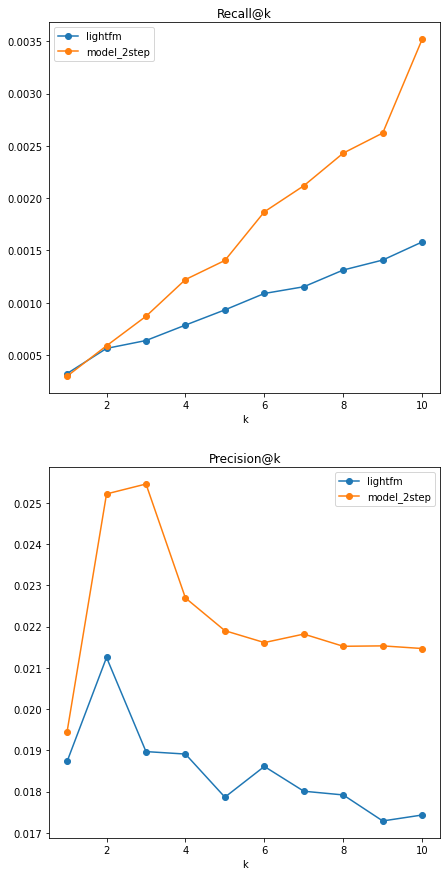

In [145]:
# Visualize metrics of two models
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(7, 15))

for indx, metric in enumerate([f'Recall@', f'Precision@']):
    for model in df_metrics.index:
        axes[indx].plot(range(1, 11), 
                        df_metrics.loc[model][[metric+f'{k}' for k in range(1, 11)]].values,
                        label=model, marker='o')
        axes[indx].legend()
        axes[indx].set_title(f'{metric}k')
        axes[indx].set_xlabel('k')

##### Conclusion
- as we can see using two stage hybrid model outperforms matrix factorization method across all metrics

##### Further Possible Improvements
- there were a lot of hyperparameters besides the hyperparameters of the models (e.g. train-valida-test split, threshhold for reducing data dimension); further hyperparameters searches for these values would probably be beneficial
- at the first stage we can have multiple simple models that can be fed to the catboost as additional features; training few more simple models would be beneficial
- genome tags feature selection can be improved and some better features can be picked/generated